Importing needed libraries:

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import math
import random
from sklearn.utils import shuffle
import seaborn as sns
import copy

#### Importing data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [35]:
train_data = pd.read_csv('train.csv')

test_data = pd.read_csv('test.csv')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### Preprocessing:

As it is obvious from the dataset, 'name', 'sex', 'ticket', 'cabin' and 'Embarked' columns are not numerical.

Features that can be omitted from the dataset:
*   PassengerId: This is just an arbitrary identifier for each passenger and does not provide any useful information for the prediction task.
*   Name: The name of the passenger is not directly related to their survival, and it would be difficult to extract any useful information from it.
* Ticket: The ticket number is also unlikely to be useful for the prediction task, and it may contain a lot of noise.
* Cabin: The cabin number is missing for many passengers, and even for those who have it, it may not be informative for the prediction task. Also, the Cabin feature has high cardinality and may result in overfitting if used as-is.
* SibSp and Parch: These features represent the number of siblings/spouses and parents/children aboard the Titanic. They may be informative for the prediction task, but it may be more useful to combine them into a single feature that represents the total number of family members on board.


In [36]:
# Defining a function to perform feature engineering and data cleaning.
def feature_omit(df):
  df['familyNo'] = df['SibSp'] + df['Parch']
  df = df.drop('SibSp', axis=1)
  df = df.drop('Parch', axis=1)

  df = df.drop('PassengerId', axis=1)
  df = df.drop('Name', axis=1)
  df = df.drop('Ticket', axis=1)
  df = df.drop('Cabin', axis=1)

  return df

In [37]:
train_data = feature_omit(train_data)

In [38]:
train_data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,familyNo
0,0,3,male,22.0,7.2500,S,1
1,1,1,female,38.0,71.2833,C,1
2,1,3,female,26.0,7.9250,S,0
3,1,1,female,35.0,53.1000,S,1
4,0,3,male,35.0,8.0500,S,0


In [39]:
test_data = feature_omit(test_data)

In [40]:
test_data.head()

,Pclass,Sex,Age,Fare,Embarked,familyNo
0,3,male,34.5,7.8292,Q,0
1,3,female,47.0,7.0000,S,1
2,2,male,62.0,9.6875,Q,0
3,3,male,27.0,8.6625,S,0
4,3,female,22.0,12.2875,S,2


Turning categorical data into numerical:\
The function cat_to_num takes a pandas DataFrame df and performs some data preprocessing on it. Specifically, it converts the 'Sex' column from categorical values ('male' and 'female') to numerical values (0 and 1) using the map() method. It also creates dummy variables for the 'Embarked' column using one-hot encoding via the get_dummies() function, concatenates these new columns with the original DataFrame using concat(), and drops the original 'Embarked' column using the drop() method. The modified DataFrame is then returned.  


In [41]:
def cat_to_num(df):
  df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
  embarked_dummies = pd.get_dummies(df['Embarked'], prefix='Embarked')
  df = pd.concat([df, embarked_dummies], axis=1)
  df = df.drop('Embarked', axis=1)
  return df

In [42]:
train_data = cat_to_num(train_data)
train_data.head()

,Survived,Pclass,Sex,Age,Fare,familyNo,Embarked_C,Embarked_Q,Embarked_S
0,0,3,0,22.0,7.2500,1,0,0,1
1,1,1,1,38.0,71.2833,1,1,0,0
2,1,3,1,26.0,7.9250,0,0,0,1
3,1,1,1,35.0,53.1000,1,0,0,1
4,0,3,0,35.0,8.0500,0,0,0,1


In [43]:
test_data = cat_to_num(test_data)
test_data.head()

,Pclass,Sex,Age,Fare,familyNo,Embarked_C,Embarked_Q,Embarked_S
0,3,0,34.5,7.8292,0,0,1,0
1,3,1,47.0,7.0000,1,0,0,1
2,2,0,62.0,9.6875,0,0,1,0
3,3,0,27.0,8.6625,0,0,0,1
4,3,1,22.0,12.2875,2,0,0,1


In [44]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    int64  
 3   Age         714 non-null    float64
 4   Fare        891 non-null    float64
 5   familyNo    891 non-null    int64  
 6   Embarked_C  891 non-null    uint8  
 7   Embarked_Q  891 non-null    uint8  
 8   Embarked_S  891 non-null    uint8  
dtypes: float64(2), int64(4), uint8(3)
memory usage: 44.5 KB


In [45]:
cols = list(train_data.columns.values)
for i in cols:
  if i != "Survived":
    train_data[i] = train_data[i].astype(float)
    test_data[i] = test_data[i].astype(float)
    # test_data[i] = standard(test_data[i])
train_data.head()

,Survived,Pclass,Sex,Age,Fare,familyNo,Embarked_C,Embarked_Q,Embarked_S
0,0,3.0,0.0,22.0,7.2500,1.0,0.0,0.0,1.0
1,1,1.0,1.0,38.0,71.2833,1.0,1.0,0.0,0.0
2,1,3.0,1.0,26.0,7.9250,0.0,0.0,0.0,1.0
3,1,1.0,1.0,35.0,53.1000,1.0,0.0,0.0,1.0
4,0,3.0,0.0,35.0,8.0500,0.0,0.0,0.0,1.0


It is obvious that 'Age' column contain null rows.

In [46]:
# Fill in missing values for 'Age' column with median
train_data['Age'] = train_data['Age'].fillna(train_data['Age'].median())

##### Visualization:

Age plot:


<Axes: >

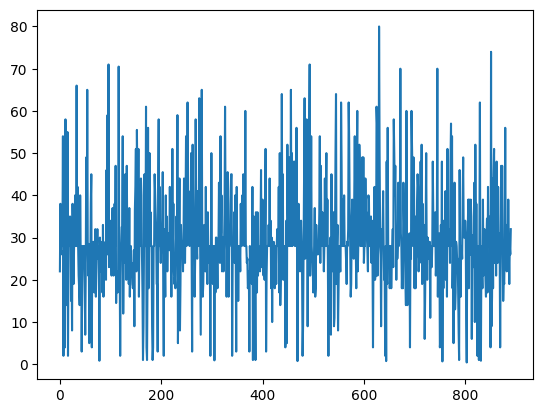

In [47]:
print("Age plot:")
train_data["Age"].plot()

Fare plot:


<Axes: >

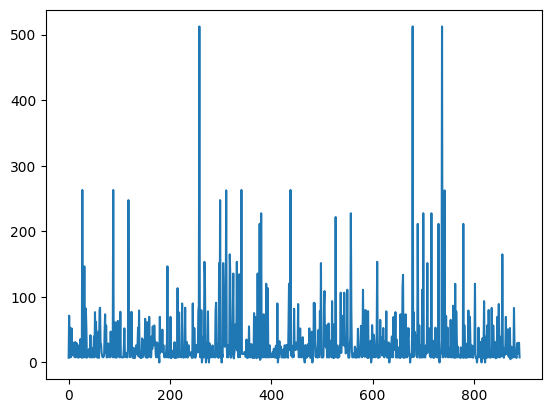

In [48]:
print("Fare plot:")
train_data["Fare"].plot()

In this section, we visualize the distributions of two key numerical features: Age and Fare. Histograms are used to provide a clear overview of the data's distribution and help us understand the central tendency and spread of these variables.

#### Age Distribution

- The "Age" distribution histogram reveals the distribution of passengers' ages on the Titanic.
- The x-axis represents different age intervals, while the y-axis shows the frequency or count of passengers falling into each interval.

#### Fare Distribution

- The "Fare" distribution histogram visualizes the distribution of ticket fares paid by passengers.
- Similar to the "Age" distribution, the x-axis represents fare intervals, and the y-axis displays the frequency or count of passengers in each interval.




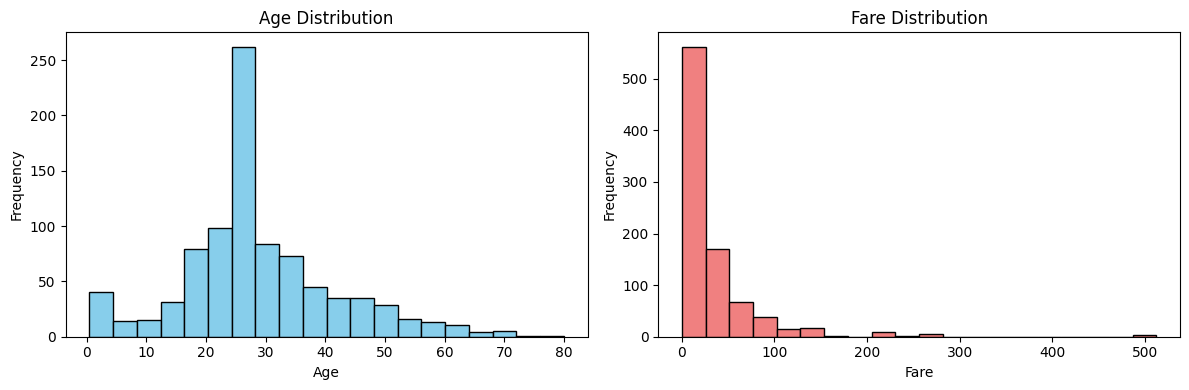

In [49]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(train_data["Age"], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')

plt.subplot(1, 2, 2)
plt.hist(train_data["Fare"], bins=20, color='lightcoral', edgecolor='black')
plt.xlabel('Fare')
plt.ylabel('Frequency')
plt.title('Fare Distribution')

plt.tight_layout()
plt.show()


In this section, we create side-by-side bar plots to visualize the relationship between survival and two categorical features: "Passenger Class" ('Pclass') and "Gender" ('Sex'). These plots provide a clear overview of how the chances of survival vary among different passenger classes and genders.


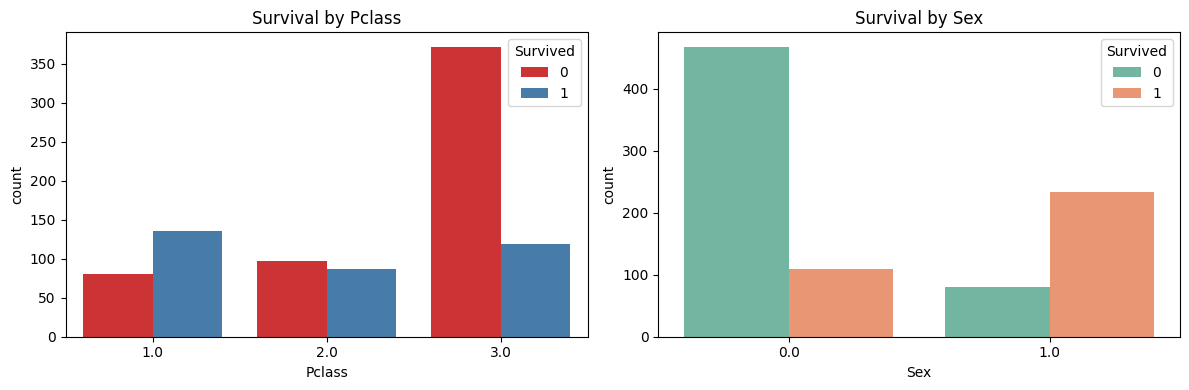

In [50]:
# Visualize the distribution of 'Pclass' and  'Sex'using bar plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.countplot(data=train_data, x='Pclass', hue='Survived', palette='Set1')
plt.title('Survival by Pclass')

plt.subplot(1, 2, 2)
sns.countplot(data=train_data, x='Sex', hue='Survived', palette='Set2')
plt.title('Survival by Sex')

plt.tight_layout()
plt.show()

 The correlation heatmap bellow displays the relationships between numerical features and survival.
 - The selected numerical features include 'Age', 'Fare', and 'familyNo'.
 - Each cell in the heatmap represents the correlation coefficient between two variables.
 - Positive values indicate a positive correlation, while negative values indicate a negative correlation.
 - Values close to 1 or -1 represent strong correlations, while values close to 0 indicate weak correlations.
 - The 'Survived' row in the heatmap shows the correlations of these numerical features with survival.


Text(0.5, 1.0, 'Correlation Heatmap')

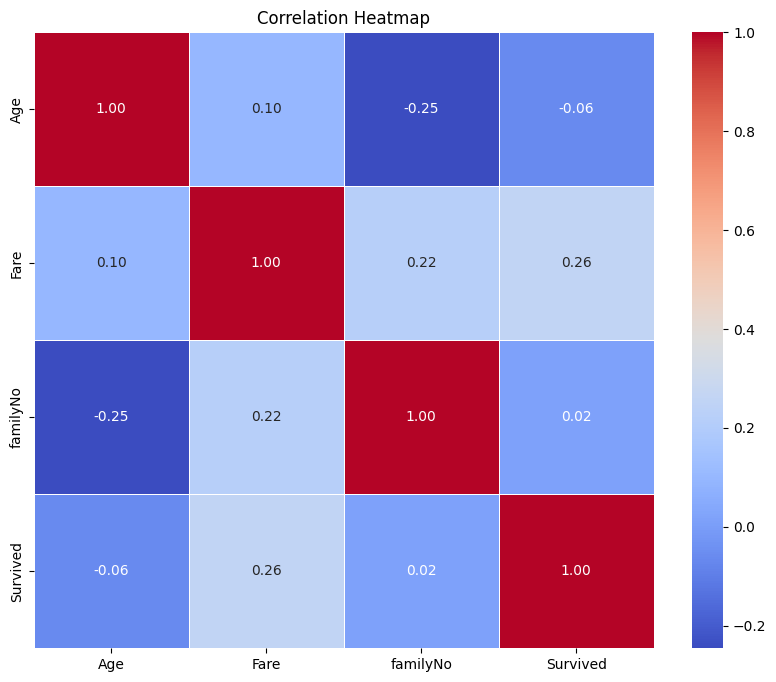

In [51]:
numerical_features = ['Age', 'Fare', 'familyNo']
corr_matrix = train_data[numerical_features + ['Survived']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Correlation Heatmap')

standardizing data:

In [52]:
def standard(x):

  s_d = np.std(x, axis=0)
  e_x = np.mean(x, axis=0)


  x_st = (x - e_x) / s_d

  return x_st 

In [56]:
train_before = copy.deepcopy(train_data)
test_before = copy.deepcopy(test_data)

In [57]:
train_data["Age"] = standard(train_data["Age"])
train_data["Fare"] = standard(train_data["Fare"])

train_data.head()

,Survived,Pclass,Sex,Age,Fare,familyNo,Embarked_C,Embarked_Q,Embarked_S
0,0,3.0,0.0,-0.565736,-0.502445,1.0,0.0,0.0,1.0
1,1,1.0,1.0,0.663861,0.786845,1.0,1.0,0.0,0.0
2,1,3.0,1.0,-0.258337,-0.488854,0.0,0.0,0.0,1.0
3,1,1.0,1.0,0.433312,0.420730,1.0,0.0,0.0,1.0
4,0,3.0,0.0,0.433312,-0.486337,0.0,0.0,0.0,1.0


In [58]:
test_data.head()

,Pclass,Sex,Age,Fare,familyNo,Embarked_C,Embarked_Q,Embarked_S
0,3.0,0.0,34.5,7.8292,0.0,0.0,1.0,0.0
1,3.0,1.0,47.0,7.0000,1.0,0.0,0.0,1.0
2,2.0,0.0,62.0,9.6875,0.0,0.0,1.0,0.0
3,3.0,0.0,27.0,8.6625,0.0,0.0,0.0,1.0
4,3.0,1.0,22.0,12.2875,2.0,0.0,0.0,1.0


In [59]:
test_data["Age"] = standard(test_data["Age"])
test_data["Fare"] = standard(test_data["Fare"])

test_data.head()

,Pclass,Sex,Age,Fare,familyNo,Embarked_C,Embarked_Q,Embarked_S
0,3.0,0.0,0.298549,-0.497811,0.0,0.0,1.0,0.0
1,3.0,1.0,1.181328,-0.512660,1.0,0.0,0.0,1.0
2,2.0,0.0,2.240662,-0.464532,0.0,0.0,1.0,0.0
3,3.0,0.0,-0.231118,-0.482888,0.0,0.0,0.0,1.0
4,3.0,1.0,-0.584229,-0.417971,2.0,0.0,0.0,1.0


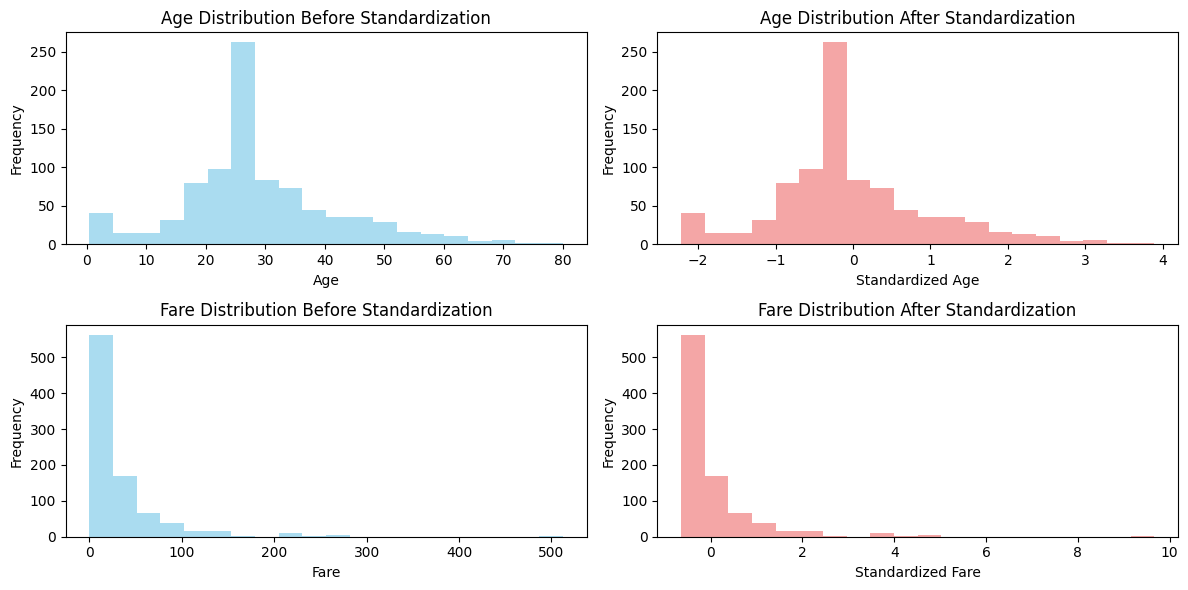

In [60]:
# Create subplots for Age and Fare before and after standardization
plt.figure(figsize=(12, 6))

# Subplot 1: Age Before Standardization
plt.subplot(2, 2, 1)
plt.hist(train_before['Age'], bins=20, color='skyblue', alpha=0.7)
plt.title('Age Distribution Before Standardization')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Subplot 2: Age After Standardization
plt.subplot(2, 2, 2)
plt.hist(train_data['Age'], bins=20, color='lightcoral', alpha=0.7)
plt.title('Age Distribution After Standardization')
plt.xlabel('Standardized Age')
plt.ylabel('Frequency')

# Subplot 3: Fare Before Standardization
plt.subplot(2, 2, 3)
plt.hist(train_before['Fare'], bins=20, color='skyblue', alpha=0.7)
plt.title('Fare Distribution Before Standardization')
plt.xlabel('Fare')
plt.ylabel('Frequency')

# Subplot 4: Fare After Standardization
plt.subplot(2, 2, 4)
plt.hist(train_data['Fare'], bins=20, color='lightcoral', alpha=0.7)
plt.title('Fare Distribution After Standardization')
plt.xlabel('Standardized Fare')
plt.ylabel('Frequency')

# Adjust the layout for better readability
plt.tight_layout()

# Show the plots
plt.show()


#### Training model:

Defining the sigmoid function used in logistic regression.

In [22]:
def sigmoid(z):
    # The sigmoid function maps any input to a value between 0 and 1
    return 1 / (1 + np.exp(-z))

Defining a function to add an intercept term to the input data.

In [23]:
def add_intercept(X):
    # Add a column of ones to the input matrix to represent the intercept term
    intercept = np.ones((X.shape[0], 1))
    return np.concatenate((intercept, X), axis=1)

    Logistic Regression with L2 Regularization.
    
    Parameters:
        X (numpy.ndarray): Input features.
        y (numpy.ndarray): Target labels.
        num_iterations (int): Number of iterations for gradient descent.
        learning_rate (float): Learning rate for gradient descent.
        alpha (float): Regularization strength (L2 penalty).

    Returns:
        numpy.ndarray: Learned model weights.

In [24]:
# with L2 regularization

def logistic_regression(X, y, num_iterations=100, learning_rate=0.1, alpha=0.1):
    # Add intercept to the input data
    X = add_intercept(X)
    # Initialize weights to zeros
    theta = np.zeros((X.shape[1],1))
    
    for i in range(num_iterations):
        # Compute the dot product of input data and weights
        z = np.dot(X, theta)
        # Apply the sigmoid function to the dot product to get the predicted probabilities
        h = sigmoid(z)
        y = y.reshape(h.shape)
        

        # Compute the gradient of the cost function with L2 regularization

        gradient = np.dot(X.T, (h - y)) / y.size + alpha * theta

        # Update the weights using the gradient and learning rate
        theta -= learning_rate * gradient
    
    return theta

    Make predictions using logistic regression model.

    Parameters:
        X (numpy.ndarray): Input features.
        theta (numpy.ndarray): Model weights.
        threshold (float): Threshold for classification.

    Returns:
        numpy.ndarray: Predicted class labels.

In [25]:
def predict(X, theta, threshold=0.5):
  
    # Add intercept to the input data
    X = add_intercept(X)
    # Predict probabilities using the learned weights
    probabilities = sigmoid(np.dot(X, theta))
    # Return predictions based on threshold
    return (probabilities >= threshold).astype(int)

    Calculate accuracy of predicted labels.

    Parameters:
        y_pred (numpy.ndarray): Predicted labels.
        y (numpy.ndarray): True labels.

    Returns:
        float: Accuracy.

In [26]:
def acc(y_pred, y):
  n = len(y_pred)

  false_ex = 0 
  for i in range(len(y_pred)) :
    if y_pred[i] != y[i]:
      false_ex += 1
  ac = n - false_ex
  ac /= n 

  return ac

In [27]:
X_train = train_data[['Pclass',
 'Sex',
 'Age',
 'Fare',
 'familyNo',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S']].copy()
X_train = X_train.values
y_train = train_data[['Survived']].copy()
y_train = y_train.values

X_test = test_data[['Pclass',
 'Sex',
 'Age',
 'Fare',
 'familyNo',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S']].copy()
X_test = X_test.values
# y_test = test_data[['Survived']].copy()
# y_test = y_test.values

In [28]:
theta = logistic_regression(X_train, y_train, num_iterations=3000, learning_rate=0.02)

In [29]:
train_pred  = predict(X_train, theta)
score = acc(train_pred, y_train)

In [30]:
score

0.7497194163860831

## Model Validation and Hyperparameter Tuning

In the following sections of the code, I are performing model validation, hyperparameter tuning, and final model training for my logistic regression model. This is a crucial part of machine learning model development to ensure my model's performance and generalization.

### Cross-Validation

The `cross_validation` function is used for k-fold cross-validation:
- `df`: The dataset
- `k`: The number of folds for cross-validation
- `iter`: The number of iterations for training
- `learning_rate`: The learning rate for gradient descent
- `alpha`: The regularization parameter

Inside the function:
- The dataset is shuffled to ensure randomness.
- The dataset is divided into `k` roughly equal parts.
- For each fold:
  - One part of the data is used as the validation set (`cv`), while the remaining data is used as the training set (`train`).
  - The model is trained using logistic regression (`logistic_regression` function) on the training set with the specified parameters.
  - Predictions are made on both the training and validation sets.
  - The accuracy of the predictions is computed for both sets and stored in `train_err_arr` and `cv_err_arr`.

The function returns two arrays: `train_err_arr` containing training accuracy for each fold, and `cv_err_arr` containing cross-validation accuracy for each fold.


In [31]:
def cross_validation(df, k, iter, learning_rate, alpha):

  #shuffling the dataset
  df = shuffle(df)

  #partitioning the dataset into k folds
  per_array = np.array_split(df.reindex(np.random.permutation(df.index)),k)

  train_err_arr = []
  cv_err_arr = []

  for i in range(k):

    #Choose the 𝑖-th group as the held-out validation group
    cv = per_array[i]

    #Train the model on all but the 𝑖-th group of data
    train =  pd.DataFrame(columns = list(df.columns))

    for j in range(k):

      if j != i:
        train = pd.concat([train, per_array[j]])

    #training model

    columns = list(df.columns)
    col = [i for i in columns if i!="Survived" ]

    #extracting x and y of train set
    y_train = np.array(train['Survived'])
    x_train = np.array(train[col]) 


    #extracting x and y of cv set
    y_cv = np.array(cv['Survived'])
    x_cv = np.array(cv[col])

    
    y_train = y_train.reshape((-1,1))
    y_train = y_train.astype(float)
    #finding weights
    w_s = logistic_regression(x_train, y_train, iter, learning_rate, alpha) 
    

    #predicting train set
    y_pred_train = predict(x_train, w_s)

    #finding prediction error
    error = acc(y_pred_train, y_train)
    train_err_arr.append(error)


    #predicting cv set
    y_pred_cv = predict( x_cv, w_s)
    #finding prediction error
    error = acc(y_pred_cv, y_cv)
    cv_err_arr.append(error)

  
  return train_err_arr, cv_err_arr

In [32]:
train_err_arr, cv_err_arr = cross_validation(train_data, 5, 1000, 0.02, 0.1)

In [33]:
def Average(lst):
    return sum(lst) / len(lst)

### Multiple Repetitions of Cross-Validation

The `cross_rep` function is used for multiple repetitions of cross-validation:
- It takes `learning_rate` and `alpha` as parameters.

Inside the function:
- It performs 10 repetitions of cross-validation using the same `cross_validation` function.
- For each repetition, the training and cross-validation accuracies are stored in `train_e` and `cv_e` arrays.
- After all repetitions, it calculates the average training and cross-validation accuracies.

The function returns the average training and cross-validation accuracies over the repetitions.


In [34]:
def cross_rep(learning_rate, alpha):

  train_e = []
  cv_e = []
  # 10 repetition
  for m in range(10):
    train_err_arr, cv_err_arr = cross_validation(train_data, 5, 1000, learning_rate, alpha)
            
    for s in range(5):
      train_e.append(train_err_arr[s])
      cv_e.append(cv_err_arr[s]) 
  train_av = Average(train_e)
  cv_av = Average(cv_e)

  return train_av, cv_av

### Hyperparameter Tuning

- I have defined a range of values for `learning_rate` and `alpha` in the `learning_arr` and `alpha_arr` arrays.
- A nested loop runs through these arrays to iterate over different combinations of hyperparameters.
- For each combination, the `cross_rep` function is called to assess the model's performance (average training and cross-validation accuracy).
- The results (learning rate, alpha, training accuracy, and cross-validation accuracy) are printed to help you choose the best hyperparameters.
- Based on these results, you have identified the best combination of hyperparameters: learning rate = 0.05 and alpha = 0.01.

In [35]:
learning_arr = [0.01, 0.05, 0.5]
alpha_arr = [0.01, 0.05, 0.5]

for l in learning_arr:
  for a in alpha_arr:
    tr_e, cv_e = cross_rep(l, a)
    print("learning rate = ", l, " , alpha = ", a, " , accuracy on train = ", tr_e*100, " , accuracy on cv = ", cv_e*100)


learning rate =  0.01  , alpha =  0.01  , accuracy on train =  76.0577911026364  , accuracy on cv =  75.55809428158938
learning rate =  0.01  , alpha =  0.05  , accuracy on train =  74.7867571741494  , accuracy on cv =  74.39859393635051
learning rate =  0.01  , alpha =  0.5  , accuracy on train =  68.7037954835558  , accuracy on cv =  68.68859456405751
learning rate =  0.05  , alpha =  0.01  , accuracy on train =  80.79129568053955  , accuracy on cv =  80.5389492185048
learning rate =  0.05  , alpha =  0.05  , accuracy on train =  79.11606284570657  , accuracy on cv =  78.45100746971313
learning rate =  0.05  , alpha =  0.5  , accuracy on train =  68.7822147280836  , accuracy on cv =  68.56280208398718
learning rate =  0.5  , alpha =  0.01  , accuracy on train =  80.64822241833053  , accuracy on cv =  80.15799384847155
learning rate =  0.5  , alpha =  0.05  , accuracy on train =  79.18342342058402  , accuracy on cv =  78.37329734479944
learning rate =  0.5  , alpha =  0.5  , accuracy 

These are the results of running a logistic regression on the Titanic dataset with different combinations of learning rate and regularization strength (alpha) hyperparameters. The model was trained on the training set and tested on the cross-validation set.

The accuracy on the training set and cross-validation set are reported for each combination of hyperparameters.

The results show that the highest accuracy on both the training and cross-validation sets was achieved with a learning rate of 0.05 and an alpha of 0.01. Lower values of learning rate and alpha resulted in lower accuracy on the training and cross-validation sets. Higher values of learning rate and alpha resulted in accuracy on the training set, but not on the cross-validation set, which indicates that the model is overfitting the training set.

From the result of the code we get that the best params are:\
**learning rate = 0.05 and alpha = 0.01**

In [36]:
theta = logistic_regression(X_train, y_train, num_iterations=3000, learning_rate=0.05, alpha = 0.01)

In [37]:
y_pred_test = predict(X_test, theta)

In [38]:
# convert predicted array into dataframe
DF = pd.DataFrame(y_pred_test)
print(DF)
 
# save the dataframe as a csv file
DF.to_csv("prediction.csv")

     0
0    0
1    0
2    0
3    0
4    1
..  ..
413  0
414  1
415  0
416  0
417  0

[418 rows x 1 columns]
